# Layer norm explorations

In [10]:
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F

import tqdm 

In [3]:
class ToyLNModel(nn.Module):
    def __init__(self, n_features, n_hidden):
        super().__init__()
        self.linear1 = nn.Linear(n_features, n_hidden)
        self.ln = nn.LayerNorm(n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_features, bias=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.ln(x)
        x = self.linear2(x)
        return x
    

In [181]:
num_steps = 100000
num_inputs = 4
num_hidden = 4
indices = [0]
log_ivl = 100
multiplier = 5

model = ToyLNModel(num_inputs, num_hidden)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

steps  = list(range(num_steps + 1))[::log_ivl]
losses = []
weights = []

for step in tqdm.trange(num_steps + 1):
    model.zero_grad()

    x = torch.randn(128, num_inputs) * multiplier
    y = model(x)

    if indices:
        loss = F.mse_loss(y[:, indices], x[:, indices])
    else:
        loss = F.mse_loss(y, x)
    loss.backward()

    optimizer.step()

    if step % log_ivl == 0:
        losses.append(loss.item())
        weights.append(deepcopy(model.state_dict()))

100%|██████████| 100001/100001 [00:55<00:00, 1814.39it/s]


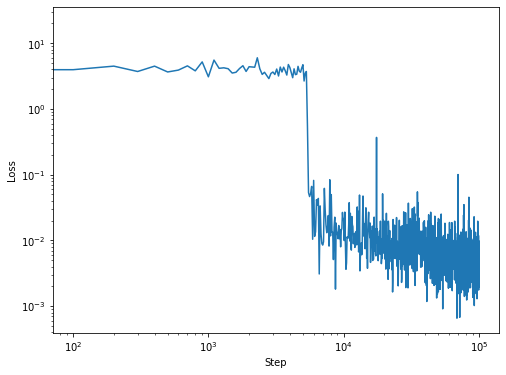

In [183]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(steps, losses)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.set_xscale('log')
fig.set_facecolor('white')

  0%|          | 0/1001 [00:00<?, ?it/s]

100%|██████████| 1001/1001 [00:00<00:00, 2306.49it/s]


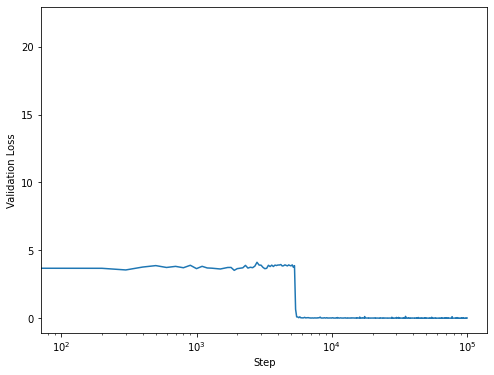

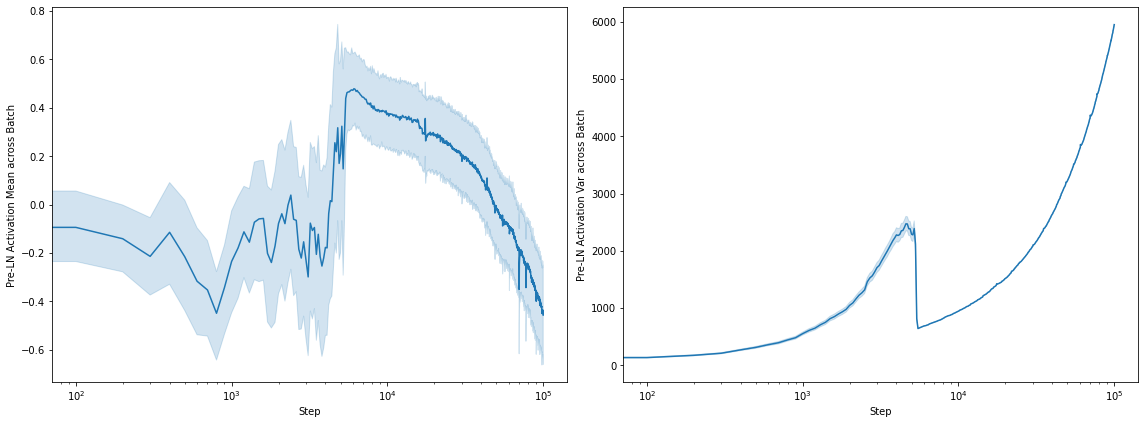

In [217]:
val_x = torch.randn(1024, num_inputs) * multiplier
val_losses = []
val_ln_means = []
val_ln_vars = []

for step, state_dict in zip(tqdm.tqdm(steps), weights):
    model.load_state_dict(state_dict)
    model.eval()
    val_y = model(val_x)
    val_loss = F.mse_loss(val_y[:, indices], val_x[:, indices])

    hidden = model.linear1(val_x)
    ln_mean = hidden.mean(dim=-1)
    ln_var = hidden.var(dim=-1)

    val_ln_means.append(ln_mean.detach().cpu().numpy())
    val_ln_vars.append(ln_var.detach().cpu().numpy())
    val_losses.append(val_loss.item())

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(steps, val_losses)
ax.set_xlabel('Step')
ax.set_ylabel('Validation Loss')
# ax.set_yscale('log')
ax.set_xscale('log')
fig.set_facecolor('white')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

activations_df = pd.DataFrame([
    {'step': step, 'mean': m, 'var': v, 'i': i} 
    for step, means, vars in zip(steps, val_ln_means, val_ln_vars) 
    for i, (m, v) in enumerate(zip(means, vars))
])

sns.lineplot(data=activations_df, x='step', y='mean', ax=axes[0])
sns.lineplot(data=activations_df, x='step', y='var', ax=axes[1])

axes[0].set_ylabel('Pre-LN Activation Mean across Batch')
axes[1].set_ylabel('Pre-LN Activation Var across Batch')

for ax in axes:
    ax.set_xlabel('Step')
    # ax.set_yscale('log')
    ax.set_xscale('log')

fig.set_facecolor('white')
plt.tight_layout()
plt.show()


In [185]:
lns = [{"step": step, "w_ln": w['ln.weight'][i].item(), "b_ln": w['ln.bias'][i].item(), "i": i} for step, w in zip(steps, weights) for i in range(num_hidden)]

df = pd.DataFrame(lns)
df

,step,w_ln,b_ln,i
0,0,1.100000,0.100000,0
1,0,1.100000,-0.100000,1
2,0,0.900000,0.100000,2
3,0,0.900000,0.100000,3
4,100,1.932597,-0.010658,0
...,...,...,...,...
3999,99900,0.033703,0.016466,3
4000,100000,0.004971,-0.001383,0
4001,100000,13.304907,-0.071093,1
4002,100000,-0.037085,-0.021280,2


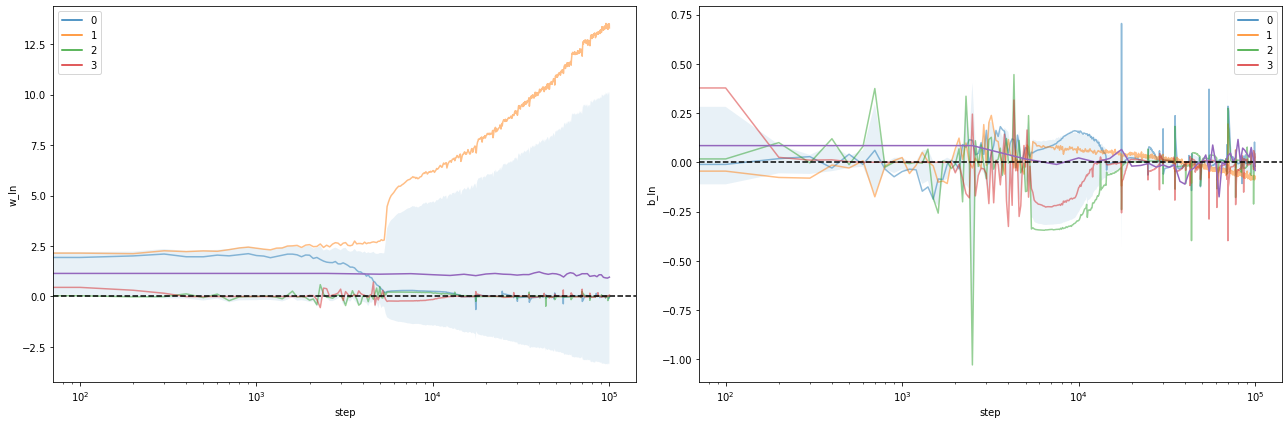

In [197]:
ALPHA = 0.5

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

w_ln_means = df.groupby('step').mean()["w_ln"]
w_ln_std = df.groupby('step').std()["w_ln"]

sns.lineplot(data=df, x="step", y="w_ln", hue="i", ax=axes[0], alpha=ALPHA, palette='tab10')
sns.lineplot(data=df, x="step", y=w_ln_means, ax=axes[0])
axes[0].fill_between(steps, w_ln_means - w_ln_std, w_ln_means + w_ln_std, alpha=0.1)

b_ln_means = df.groupby('step').mean()["b_ln"]
b_ln_std = df.groupby('step').std()["b_ln"]

sns.lineplot(data=df, x="step", y="b_ln", hue="i", ax=axes[1], alpha=ALPHA, palette='tab10')
sns.lineplot(data=df, x="step", y=b_ln_means, ax=axes[1])
axes[1].fill_between(steps, b_ln_means - b_ln_std, b_ln_means + b_ln_std, alpha=0.1)

for ax in axes:
    ax.axhline(0, color='black', linestyle='--')
    ax.set_xscale("log")
    # ax.set_yscale('symlog')

plt.tight_layout()
fig.set_facecolor('white')
plt.show()

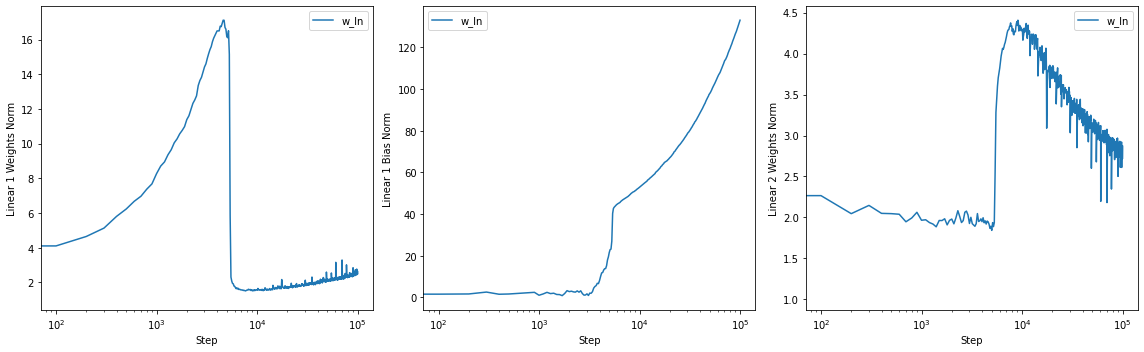

In [187]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].plot(steps, [w['linear1.weight'].norm().item() for w in weights], label="w_ln")
axes[1].plot(steps, [w['linear1.bias'].norm().item() for w in weights], label="w_ln")
axes[2].plot(steps, [w['linear2.weight'].norm().item() for w in weights], label="w_ln")

for ax, label in zip(axes.flatten(), ["Linear 1 Weights", "Linear 1 Bias", "Linear 2 Weights"]):
    ax.set_xscale("log")
    ax.legend()
    ax.set_xlabel("Step")
    ax.set_ylabel(f"{label} Norm")

plt.tight_layout()
fig.set_facecolor('white')

  0%|          | 0/1001 [00:00<?, ?it/s]

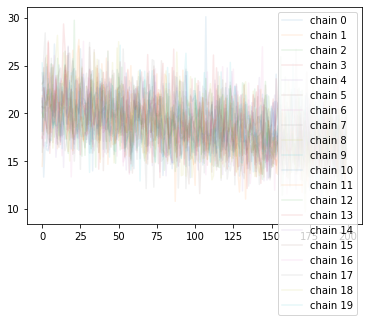

  0%|          | 1/1001 [00:04<1:20:54,  4.85s/it]

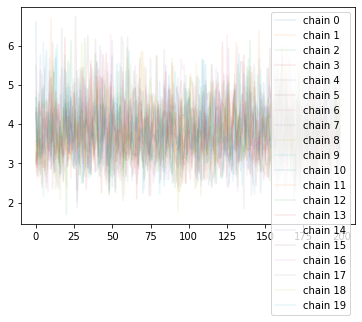

  0%|          | 2/1001 [00:09<1:22:06,  4.93s/it]

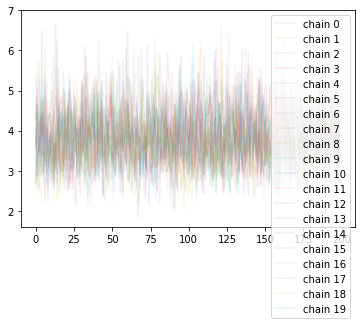

  0%|          | 3/1001 [00:14<1:21:14,  4.88s/it]

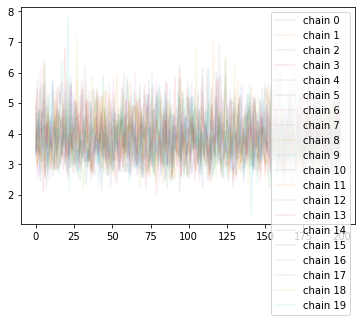

  0%|          | 4/1001 [00:19<1:23:02,  5.00s/it]


KeyboardInterrupt: 

: 

In [234]:
from devinterp.slt.llc import estimate_learning_coeff_with_summary
from devinterp.optim import SGLD
from torch.utils.data import DataLoader, TensorDataset

num_chains = 20

xs = torch.randn(2**20, num_inputs) * multiplier
dataset = TensorDataset(xs, xs)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

rlcts = []

for step, state_dict in tqdm.tqdm(zip(steps[::10], weights[::10]), total=len(steps)):
    model.load_state_dict(state_dict)

    rlct = estimate_learning_coeff_with_summary(
        model,
        dataloader,
        lambda x, y: F.mse_loss(x[:, indices], y[:, indices]),
        SGLD,
        optimizer_kwargs={"lr": 0.00001, "num_samples": 256, "elasticity": 1000},
        num_draws=200,
        num_chains=num_chains,
        verbose=False,
    )
    for chain in range(num_chains):
        plt.plot(rlct["loss/trace"][chain], label=f"chain {chain}", alpha=0.1)

    plt.legend()
    plt.show()

    del rlct["loss/trace"]
    rlct['step'] = step
    rlcts.append(rlct)

In [229]:
# rlcts = [{**rlct, "step": step} for rlct, step in zip(rlcts, steps[::10])]
rlcts

[{'llc/mean': -1145753.75,
  'llc/std': 3603.679443359375,
  'llc-chain/0': -1144254.5,
  'llc-chain/1': -1140486.5,
  'llc-chain/2': -1151405.75,
  'llc-chain/3': -1147400.625,
  'llc-chain/4': -1145221.25,
  'step': 0},
 {'llc/mean': -5266.78564453125,
  'llc/std': 1425.5177001953125,
  'llc-chain/0': -3656.0419921875,
  'llc-chain/1': -5997.95068359375,
  'llc-chain/2': -3505.53271484375,
  'llc-chain/3': -6116.8828125,
  'llc-chain/4': -7057.52001953125,
  'step': 1000},
 {'llc/mean': 35841.80078125,
  'llc/std': 5471.12744140625,
  'llc-chain/0': 31966.76953125,
  'llc-chain/1': 45907.765625,
  'llc-chain/2': 37221.2265625,
  'llc-chain/3': 30880.041015625,
  'llc-chain/4': 33233.203125,
  'step': 2000},
 {'llc/mean': -43105.5078125,
  'llc/std': 2789.74658203125,
  'llc-chain/0': -43207.203125,
  'llc-chain/1': -42464.66796875,
  'llc-chain/2': -42019.3984375,
  'llc-chain/3': -48160.30078125,
  'llc-chain/4': -39675.953125,
  'step': 3000},
 {'llc/mean': -10875.486328125,
  'llc

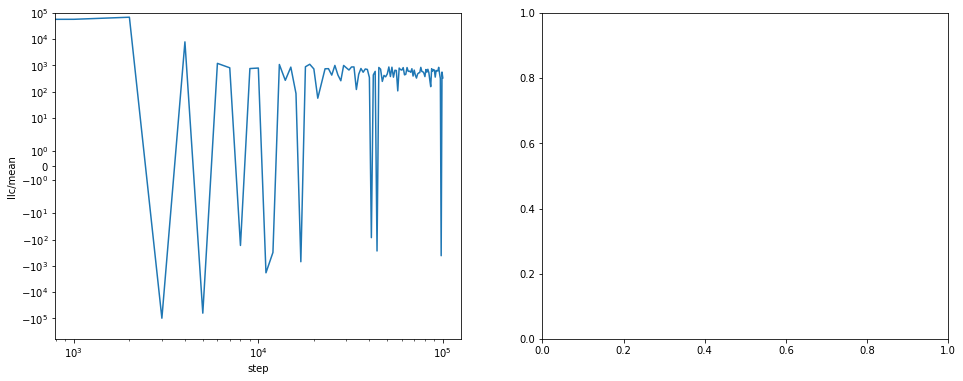

In [233]:
llc_df = pd.DataFrame(rlcts)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
sns.lineplot(data=llc_df, x="step", y="llc/mean", ax=axes[0])
ax.set_xscale('log')
ax.set_yscale('symlog')